In [1]:
import time
import numpy as np
from scipy import linalg as LA
from matplotlib import pyplot as plt
%matplotlib inline

## Helper Functions

In [2]:
def smart_eigh(A, B, **kargs):
    block_size = B.shape[0]
    return LA.eigh(A, B + np.eye(block_size) * 1e-10, **kargs)

In [3]:
def sqr(mat):
    return mat @ mat

In [4]:
def get_gaussian_kernel(X, gamma):
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i, j] = np.exp(-(1/gamma**2) * LA.norm(X[i] - X[j])**2)
    return K

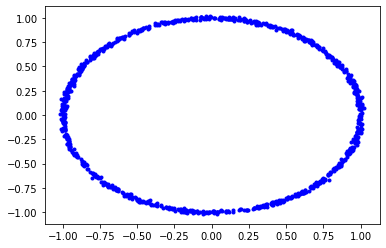

In [5]:
N = 1000
sigma = 0.01
t = np.random.uniform(0, 2 * np.pi, size=(N, 1))
n1 = np.random.normal(0, sigma, (N, 1))
n2 = np.random.normal(0, sigma, (N, 1))
X = np.sin(t) + n1 # (N, 1)
Y = np.cos(t) + n2 # (N, 1)
plt.plot(X, Y, "b.")
gamma = 1
eta = 1e-4

K = get_gaussian_kernel(X, gamma)
L = get_gaussian_kernel(Y, gamma)
H = np.eye(N) - (1/N * np.ones(N))
Ktilde = H @ K @ H
Ltilde = H @ L @ H
Z = np.zeros((N, N))

A = np.block([
    [Z, (1/N * Ktilde @ Ltilde)],
    [(1/N * Ltilde @ Ktilde), Z]
])

B = np.block([
    [Ktilde, Z],
    [Z, Ltilde]
])

In [6]:
def get_exact_COCO():
    N = X.shape[0]
    
    eigvals, eigvecs = smart_eigh(A, B) # results sorted low->high

    coco = eigvals[-1]

    alpha = np.sqrt(2) * eigvecs[0:N, -1]
    beta = np.sqrt(2) * eigvecs[N:(2*N), -1]
    
    assert np.allclose(alpha.T @ Ktilde @ alpha, 1)
    assert np.allclose(beta.T @ Ltilde @ beta, 1)

    f = K @ H @ alpha
    g = L @ H @ beta

    return f, g, coco
tic = time.perf_counter()
f_exact, g_exact, coco_exact = get_exact_COCO()
print("Took", time.perf_counter() - tic)

Took 0.9465486359549686


In [7]:
def incomplete_cholesky_decomposition(K, eta):
    ell, ell = K.shape
    j, nu = 0, []
    R = np.zeros((ell, ell))
    d = K.diagonal().copy()
    a, I = d.max(), [d.argmax()] # [a,I(1)] = max(d);
    while a > eta:
        nu.append(np.sqrt(a))
        for i in range(ell):
            R[j, i] = (K[I[j], i] - R[:, i].T @ R[:, I[j]])/nu[j]
            d[i] = d[i] - R[j, i] ** 2
        a, I = d.max(), I + [d.argmax()] # [a,I(j+1)] = max(d);
        j += 1
    T = j
    return R[0:T, :]

def get_efficient_COCO():
    N = X.shape[0]
    eta = 1e-10
    
    R = incomplete_cholesky_decomposition(B, eta)
    Atilde = LA.pinv(R.T) @ A @ LA.pinv(R)
    eigvals, eigvecs = LA.eigh(Atilde)
    
    coco = eigvals[-1]
    
    eigvecs_reg = LA.pinv(R) @ eigvecs[:, -1]
    alpha = np.sqrt(2) * eigvecs_reg[N:(2*N)]
    beta = np.sqrt(2) * eigvecs_reg[0:N]

    assert np.allclose(alpha.T @ Ktilde @ alpha, 1, atol=2e-1), alpha.T @ Ktilde @ alpha
    assert np.allclose(beta.T @ Ltilde @ beta, 1, atol=2e-1), beta.T @ Ltilde @ beta
    
    f = K @ H @ alpha
    g = L @ H @ beta

    return f, g, coco

tic = time.perf_counter()
f_eff, g_eff, coco_eff = get_efficient_COCO()
print("Took", time.perf_counter() - tic)

Took 0.7613039390416816


Exact COCO: 0.0925856, Efficient COCO: 0.0925856


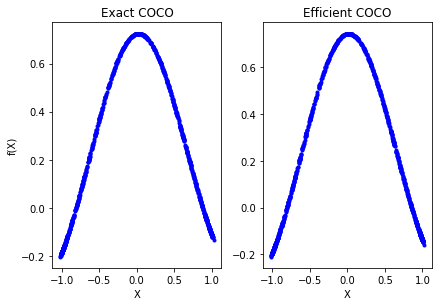

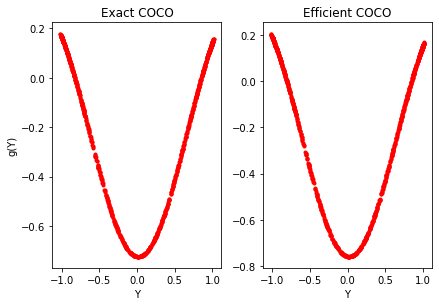

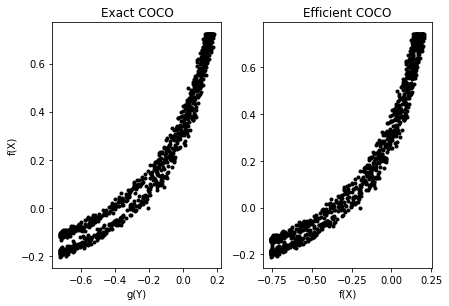

In [8]:
print("Exact COCO: {:.7f}, Efficient COCO: {:.7f}".format(coco_exact, coco_eff))

fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(X, f_exact, "b.")
axs[0].set_title("Exact COCO")
axs[0].set_xlabel("X")
axs[0].set_ylabel("f(X)")
axs[1].plot(X, f_eff, "b.")
axs[1].set_title("Efficient COCO")
axs[1].set_xlabel("X")

plt.show()
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(Y, g_exact, "r.")
axs[0].set_title("Exact COCO")
axs[0].set_xlabel("Y")
axs[0].set_ylabel("g(Y)")
axs[1].plot(Y, g_eff, "r.")
axs[1].set_title("Efficient COCO")
axs[1].set_xlabel("Y")
plt.show()

fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(g_exact, f_exact, "k.")
axs[0].set_title("Exact COCO")
axs[0].set_xlabel("g(Y)")
axs[0].set_ylabel("f(X)")
axs[1].plot(g_eff, f_eff, "k.")
axs[1].set_title("Efficient COCO")
axs[1].set_xlabel("f(X)")
plt.show()


In [9]:
def get_kernel_cca():
    N = X.shape[0]
    
    reg = 1e-1

    A = np.block([
        [Z, (1/N * Ktilde @ Ltilde)],
        [(1/N * Ltilde @ Ktilde), Z]
    ])

    B = np.block([
        [sqr(Ktilde) + reg * Ktilde, Z],
        [Z, sqr(Ltilde) + reg * Ltilde]
    ])
    
    eigvals, eigvecs = smart_eigh(A, B)
        
    cca = eigvals[-1] * N
    
    alpha = np.sqrt(2) * np.sqrt(N) * eigvecs[0:N, -1]
    beta = np.sqrt(2) * np.sqrt(N) * eigvecs[N:(2*N), -1]

    assert np.allclose(1/N * alpha.T @ sqr(Ktilde) @ alpha, 1, atol=1e-1), 1/N * alpha.T @ Ktilde @ Ktilde @ alpha
    assert np.allclose(1/N * beta.T @ sqr(Ltilde) @ beta, 1, atol=1e-1), 1/N * beta.T @ Ktilde @ Ktilde @ beta

    f = K @ H @ alpha
    g = L @ H @ beta
    
    return f, g, cca
tic = time.perf_counter()
f_cca, g_cca, cca = get_kernel_cca()
print("Took", time.perf_counter() - tic)

Took 1.0942842699587345


CCA 0.9964778732837055


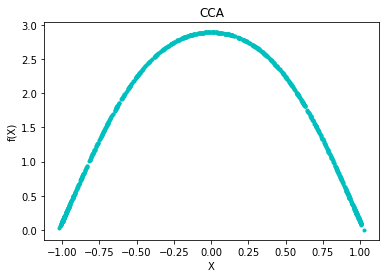

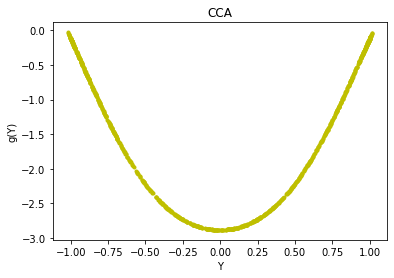

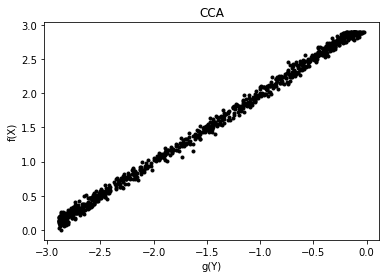

In [10]:
print("CCA", cca)

plt.title("CCA")
plt.plot(X, f_cca, "c.")
plt.xlabel("X")
plt.ylabel("f(X)")
plt.show()

plt.title("CCA")
plt.plot(Y, g_cca, "y.")
plt.xlabel("Y")
plt.ylabel("g(Y)")
plt.show()

plt.title("CCA")
plt.plot(g_cca, f_cca, "k.")
plt.xlabel("g(Y)")
plt.ylabel("f(X)")
plt.show()

CCA 0.9964778732837055


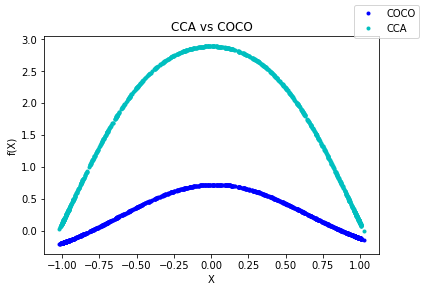

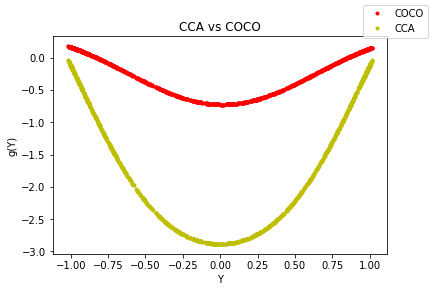

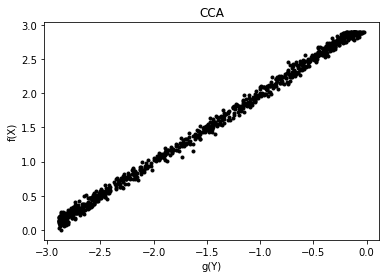

In [11]:
print("CCA", cca)

plt.title("CCA vs COCO")
plt.plot(X, f_exact, "b.")
plt.plot(X, f_cca, "c.")
plt.figlegend(("COCO", "CCA"))
plt.xlabel("X")
plt.ylabel("f(X)")
plt.show()

plt.title("CCA vs COCO")
plt.plot(Y, g_exact, "r.")
plt.plot(Y, g_cca, "y.")
plt.figlegend(("COCO", "CCA"))
plt.xlabel("Y")
plt.ylabel("g(Y)")
plt.show()

plt.title("CCA")
plt.plot(g_cca, f_cca, "k.")
plt.xlabel("g(Y)")
plt.ylabel("f(X)")
plt.show()